# Libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
#from sklearn.preprocessing import Normalizer
#from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

Download the data

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c dsba-fm-centralesupelec-ml-course

! unzip /content/dsba-fm-centralesupelec-ml-course.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 133MB/s]
Archive:  /content/dsba-fm-centralesupelec-ml-course.zip
  inflating: sample_submission.csv   
  inflating: skeleton_code.py        
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
## Read csvs

train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

print(len(train_df),len(test_df))

# Concatenate both the train data and test data to ensure the same processing
train_df = pd.concat([train_df,test_df]).reset_index(drop=True)

print(len(train_df))
# Knowing the data roughly
print(train_df.dtypes)

pd.set_option('display.max_columns', None)
print(train_df.head())

80176 34365
114541
date                 object
org                  object
tld                  object
ccs                   int64
bcced                 int64
mail_type            object
images                int64
urls                  int64
salutations           int64
designation           int64
chars_in_subject    float64
chars_in_body         int64
label               float64
dtype: object
                                    date          org           tld  ccs  \
0         Mon, 6 Nov 2017 11:13:45 +0100        reply       ebay.in    0   
1        Wed, 14 Feb 2018 11:00:16 -0000          edm  efinmail.com    0   
2         Wed, 6 Jul 2016 19:53:37 +0000  usebackpack           com    0   
3        Fri, 11 Oct 2019 11:25:40 +0200     granular            ai    0   
4  Tue, 07 Nov 2017 11:07:18 +0000 (UTC)       github           com    1   

   bcced              mail_type  images  urls  salutations  designation  \
0      0  multipart/alternative      35   120            0            0

# Pre-processing analysis

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

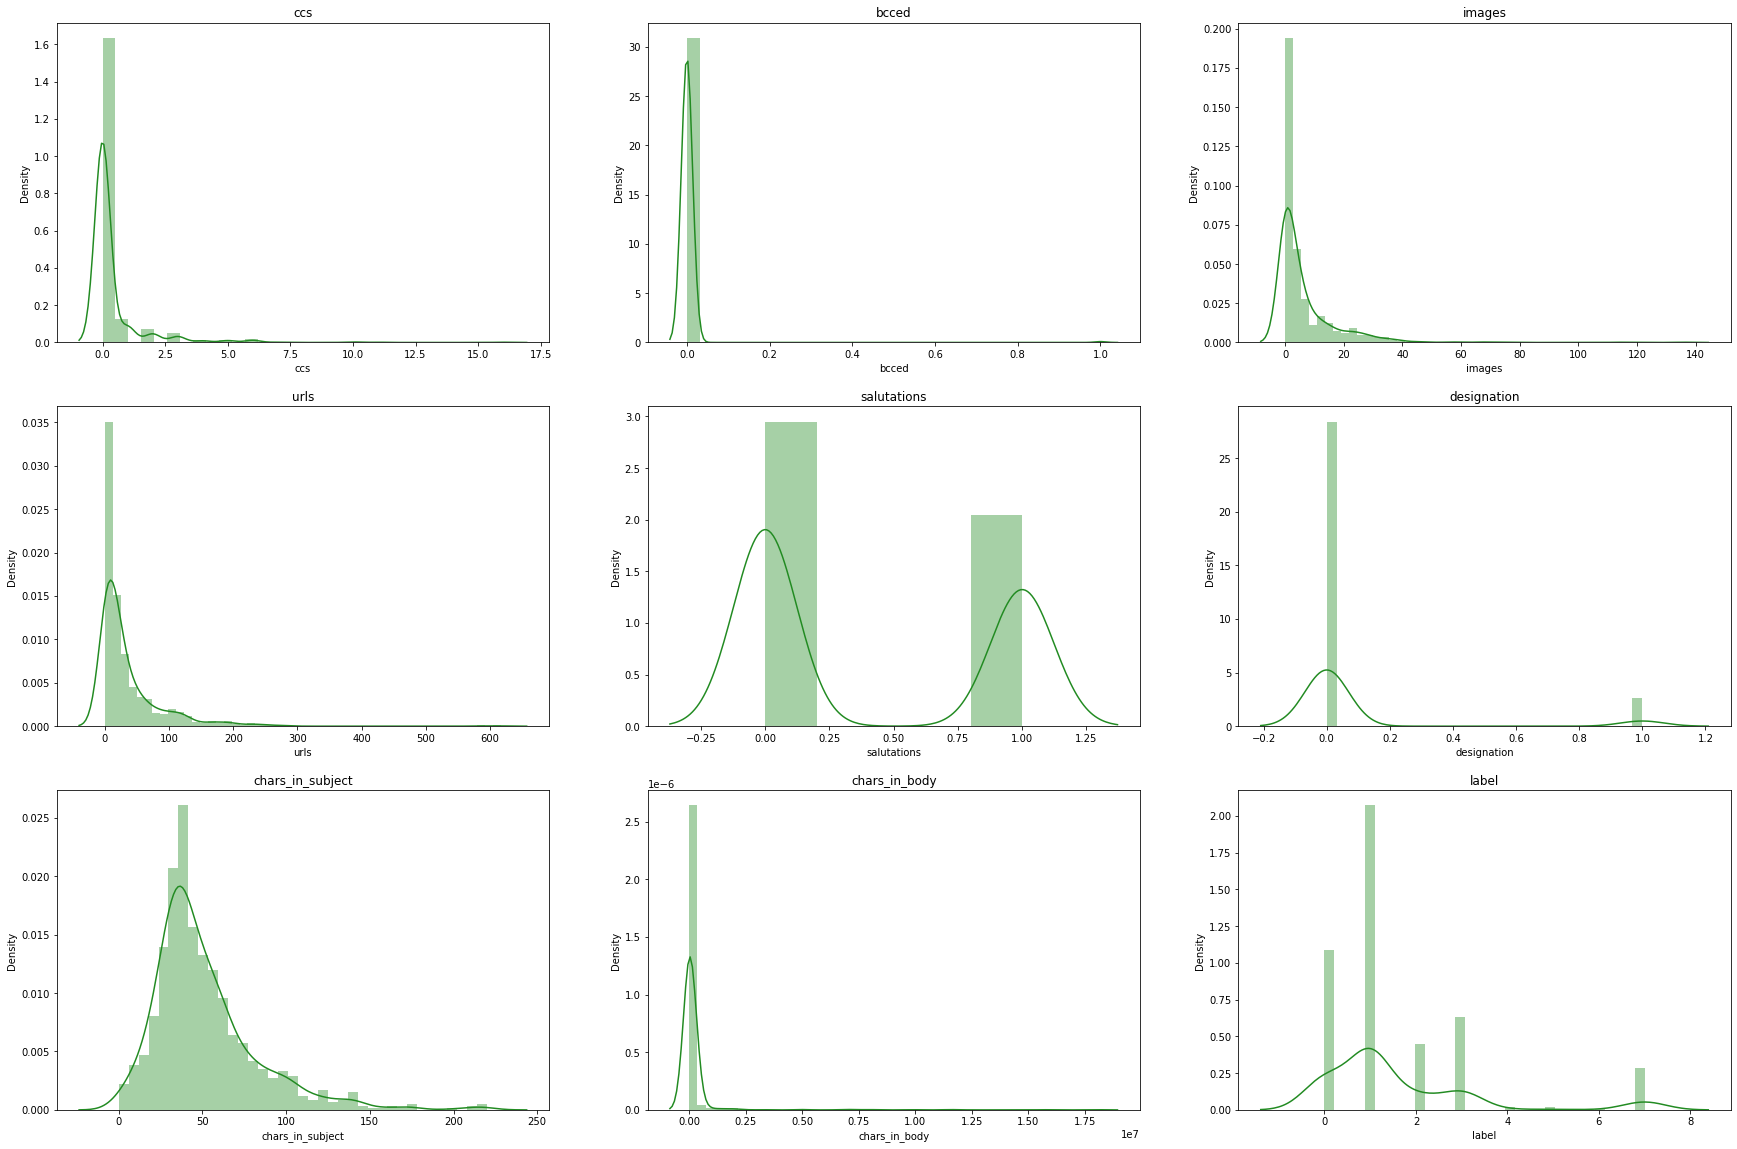

In [ ]:
# Viewing the distribution of numerical data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = train_df.select_dtypes(include=numerics)
newdf=newdf.sample(1000)


fig, axes = plt.subplots(nrows = 3, ncols = 3)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(30, 20)

for ax, col in zip(axes, newdf.columns):
  sns.distplot(newdf[col], ax = ax, color='forestgreen')
  ax.set_title(col)

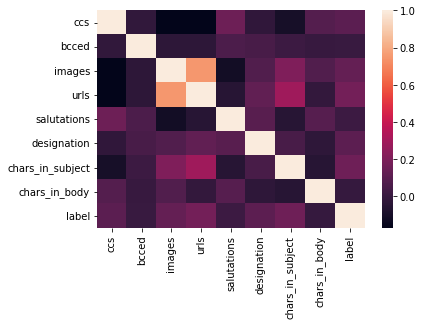

In [ ]:
# The correlation between numerical data
sns.heatmap(newdf.corr())

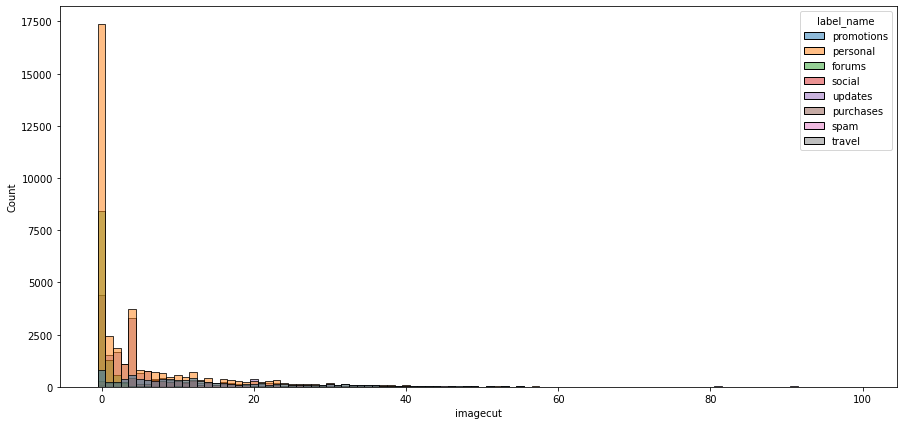

In [ ]:
# View the distribution of labels with respect to the feature images
train_df['label_name'] = train_df['label'].map({0:'updates',1:'personal',2:'promotions',3:'forums',4:'purchases',5:'travel',6:'spam',7:'social'})
df1 = train_df[['images','label_name']]
df1 = df1[df1['images']<100]
images_cut = pd.cut(x = df1['images'],bins = 100,labels = range(0,100))
df1['imagecut'] = images_cut
para1='imagecut'
plt.figure(figsize=(15,7))
sns.histplot(data = df1.dropna(), x = para1, hue= 'label_name')
train_df = train_df.drop(columns='label_name')

In [ ]:
# See the total numbers of different labels in data set 
print(train_df.value_counts(['label']))

label
1.0      37195
0.0      17995
3.0      10727
2.0       8567
7.0       5042
4.0        357
6.0        152
5.0        141
dtype: int64


In [ ]:
# Find NAs

train_df.count()

date                114541
org                 109554
tld                 109552
ccs                 114541
bcced               114541
mail_type           114289
images              114541
urls                114541
salutations         114541
designation         114541
chars_in_subject    114519
chars_in_body       114541
label                80176
dtype: int64

# Preprocessing

In [ ]:

# encode the date

train_df['date'] = pd.to_datetime(train_df['date'], errors='coerce', infer_datetime_format=True, utc=True)

# create time related features

train_df['off_hrs'] = train_df['date'].apply(lambda x: 1 if x.hour < 8 else 0)
train_df['work_hrs'] = train_df['date'].apply(lambda x: 1 if ((x.hour >= 8) & (x.hour < 18) & (x.weekday() <= 5)) else 0)
train_df['aft_work_hrs'] = train_df['date'].apply(lambda x: 1 if ((x.hour >= 18) & (x.weekday() <= 5)) else 0)
train_df['wk_end'] = train_df['date'].apply(lambda x: 1 if x.weekday() > 5 else 0)
# to recognize forums
train_df['time3'] = train_df['date'].apply(lambda x:1 if x.month in [8] else 0)
# to recognize spams
train_df['time6'] = train_df['date'].apply(lambda x:1 if x.month in [10] else 0)
# to recognize purchases
train_df['time4'] = train_df['date'].apply(lambda x:1 if [11,12] else 0) 

# clean all str columns

train_df['org'] = train_df['org'].fillna('no_entry').astype(str).str.lower().str.strip()
train_df['tld'] = train_df['tld'].fillna('no_entry').astype(str).str.lower().str.strip()
train_df['mail_type'] = train_df['mail_type'].fillna('no_entry').astype(str).str.lower().str.strip()
train_df['mail_type'] = train_df['mail_type'].apply(lambda x: x.replace('/','_'))

# combine org and tld

train_df['sender'] = train_df['org']+'.'+train_df['tld']

# fill na in chars_in_subject col and create a binary feature for if na in email subject

train_df['subject_na'] = 0
train_df.loc[train_df['chars_in_subject'].isna(),'subject_na'] = 1
train_df['chars_in_subject'] = train_df['chars_in_subject'].fillna(0)

# interaction features
# extract emails with large body content
train_df['subject_body']= train_df['chars_in_subject'] / train_df['chars_in_body']*1000
train_df['subject_body'] = train_df['subject_body'].apply(lambda x:1 if x>=1000 else 0)

#ratio

#train_df['ratio_pic_url'] = train_df['urls'] / (train_df['images']+1)
#train_df['ratio_char'] = train_df['chars_in_subject'] / (train_df['chars_in_body']+1)

# log(x+1) transform of continuous columns

train_df['log_ccs'] = np.log(train_df['ccs']+1)
train_df['log_images'] = np.log(train_df['images']+1)
# reduce the colinearity between images and urls
train_df['log_urls_images'] = np.log(train_df['urls']+1)-train_df['log_images']
train_df['log_subject_char'] = np.log(train_df['chars_in_subject']+1)
train_df['log_body_char'] = np.log(train_df['chars_in_body']+1)

# checks if continuous columns are zero
# may help to recognize social emails
train_df['zero_ccs'] = train_df['ccs'].apply(lambda x: 1 if x == 0 else 0)

# feature scaling

numeric_cols = ['log_ccs','log_images','log_urls_images','log_subject_char','log_body_char']

scaler = RobustScaler()
scaler.fit(train_df[numeric_cols])
scaler = scaler.transform(train_df[numeric_cols])
scaler = pd.DataFrame(scaler,columns=numeric_cols)
train_df[numeric_cols] = scaler

# one hot encoding for mail types

train_df['type'] = 1
mail_type_pivoted = train_df.pivot(columns='mail_type',values='type').fillna(0)
train_df = train_df.join(mail_type_pivoted)

# assign the weight to the email address according to the probability of labels appear in the training set

train_df['type'] = 1
labelled = train_df.dropna(subset=['label'])
labelled['label_name'] = labelled['label'].map({0:'updates',1:'personal',2:'promotions',3:'forums',4:'purchases',5:'travel',6:'spam',7:'social'})
label_pivoted = labelled.pivot(columns='label_name',values='type').fillna(0)
labelled = labelled.join(label_pivoted)
labelled = labelled[['sender','forums','personal','promotions','purchases','social','spam','travel','updates']].groupby('sender').mean().reset_index()
train_df = pd.merge(train_df,labelled,on='sender',how='left')

# drop irrelevant columns

train_df = train_df.drop(columns = ['date','org','tld','mail_type','sender','type','images','urls','chars_in_subject','chars_in_body','bcced','multipart_report'])

# split the concatenated data set into training set and test set again

test_df = train_df[train_df['label'].isna()].copy()
test_df = test_df.fillna(0).drop(columns='label').reset_index(drop=True)
train_df = train_df.dropna(subset=['label'])
train_df['label'] = train_df['label'].astype('int64')

train_df

<ipython-input-12-fcc71a2edbde>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled['label_name'] = labelled['label'].map({0:'updates',1:'personal',2:'promotions',3:'forums',4:'purchases',5:'travel',6:'spam',7:'social'})


,ccs,salutations,designation,label,off_hrs,work_hrs,aft_work_hrs,wk_end,time3,time6,time4,subject_na,subject_body,log_ccs,log_images,log_urls_images,log_subject_char,log_body_char,zero_ccs,multipart_alternative,multipart_idm,multipart_mixed,multipart_related,multipart_signed,no_entry,text_calendar,text_html,text_plain,forums,personal,promotions,purchases,social,spam,travel,updates
0,0,0,0,2,0,1,0,0,0,0,1,0,0,0.000000,1.130930,-1.812688e-01,0.233246,0.612249,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.503836,0.475703,0.000000,0.0,0.00000,0.00000,0.020460
1,0,0,0,1,0,1,0,0,0,0,1,0,0,0.000000,-0.184535,-2.312902e-16,1.424207,-0.836404,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.455224,0.052239,0.000000,0.0,0.00000,0.00000,0.492537
2,0,0,0,1,0,0,1,0,0,0,1,0,0,0.000000,0.232487,-1.097476e-01,-0.274781,0.103577,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.504142,0.046943,0.000000,0.0,0.00000,0.00000,0.448915
3,0,0,0,1,0,1,0,0,0,1,1,0,0,0.000000,-0.500000,-1.444017e+00,-1.528874,1.522665,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238516,0.733216,0.001767,0.000000,0.0,0.00000,0.00000,0.026502
4,1,0,0,1,0,1,0,0,0,0,1,0,0,0.693147,0.000000,0.000000e+00,0.233246,-0.936994,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.626853,0.182867,0.000000,0.000000,0.0,0.00000,0.00000,0.190280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80171,1,0,0,3,0,1,0,0,0,0,1,0,0,0.693147,-0.500000,8.446960e-01,1.176240,-1.195595,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.626853,0.182867,0.000000,0.000000,0.0,0.00000,0.00000,0.190280
80172,0,1,0,0,1,0,0,0,0,0,1,0,0,0.000000,-0.500000,-2.996607e-01,0.839533,-0.170976,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.048392,0.491742,0.004926,0.013909,0.0,0.00029,0.01275,0.427992
80173,0,0,0,0,0,1,0,0,0,0,1,0,0,0.000000,1.016552,-2.751504e-01,0.137556,0.158313,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.238303,0.003342,0.002314,0.0,0.00000,0.00000,0.756041
80174,0,1,1,0,0,1,0,0,0,0,1,0,0,0.000000,1.091329,6.227299e-01,2.125797,0.732754,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.294385,0.142640,0.000000,0.0,0.00000,0.00000,0.562974


In [ ]:
train_df.columns

Index(['ccs', 'salutations', 'designation', 'label', 'off_hrs', 'work_hrs',
       'aft_work_hrs', 'wk_end', 'time3', 'time6', 'time4', 'subject_na',
       'subject_body', 'log_ccs', 'log_images', 'log_urls_images',
       'log_subject_char', 'log_body_char', 'zero_ccs',
       'multipart_alternative', 'multipart_idm', 'multipart_mixed',
       'multipart_related', 'multipart_signed', 'no_entry', 'text_calendar',
       'text_html', 'text_plain', 'forums', 'personal', 'promotions',
       'purchases', 'social', 'spam', 'travel', 'updates'],
      dtype='object')

In [ ]:
print(train_df.head())
print(len(train_df.columns))

   ccs  salutations  designation  label  off_hrs  work_hrs  aft_work_hrs  \
0    0            0            0      2        0         1             0   
1    0            0            0      1        0         1             0   
2    0            0            0      1        0         0             1   
3    0            0            0      1        0         1             0   
4    1            0            0      1        0         1             0   

   wk_end  time3  time6  time4  subject_na  subject_body   log_ccs  \
0       0      0      0      1           0             0  0.000000   
1       0      0      0      1           0             0  0.000000   
2       0      0      0      1           0             0  0.000000   
3       0      0      1      1           0             0  0.000000   
4       0      0      0      1           0             0  0.693147   

   log_images  log_urls_images  log_subject_char  log_body_char  zero_ccs  \
0    1.130930    -1.812688e-01          0.233

# After processing analysis

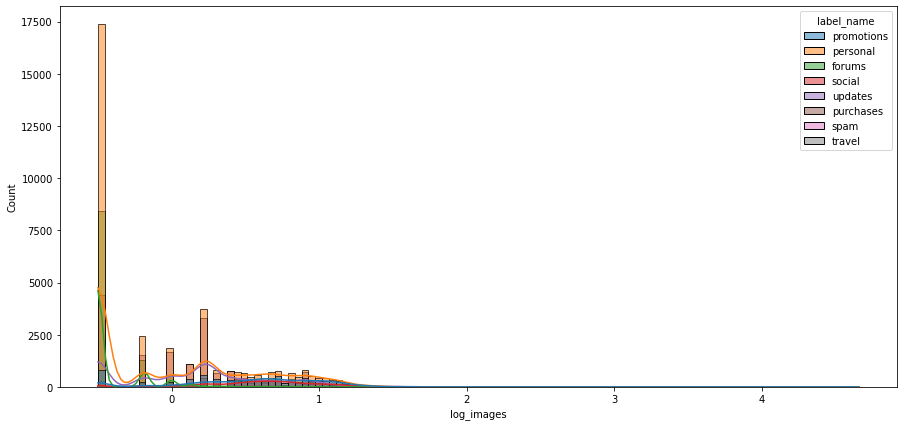

In [ ]:
train_df['label_name'] = train_df['label'].map({0:'updates',1:'personal',2:'promotions',3:'forums',4:'purchases',5:'travel',6:'spam',7:'social'})

para='log_images'
plt.figure(figsize=(15,7))
sns.histplot(data = train_df.dropna(), x = para, kde=True, hue= 'label_name')

train_df = train_df.drop(columns='label_name')

In [ ]:
train_df['label_name'] = train_df['label'].map({0:'updates',1:'personal',2:'promotions',3:'forums',4:'purchases',5:'travel',6:'spam',7:'social'})

print(train_df[train_df[para]==0].dropna().value_counts(['label_name',para]))

train_df = train_df.drop(columns='label_name')

label_name  log_images
personal    0.0           1867
updates     0.0           1674
forums      0.0            580
promotions  0.0            232
social      0.0            183
purchases   0.0             24
spam        0.0             14
travel      0.0              2
dtype: int64


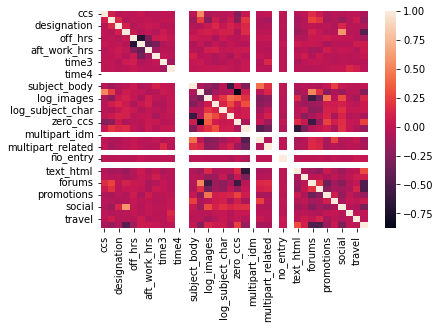

In [ ]:
# The correlation between the features
df_new1 = train_df.sample(1000)
sns.heatmap(df_new1.corr())

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

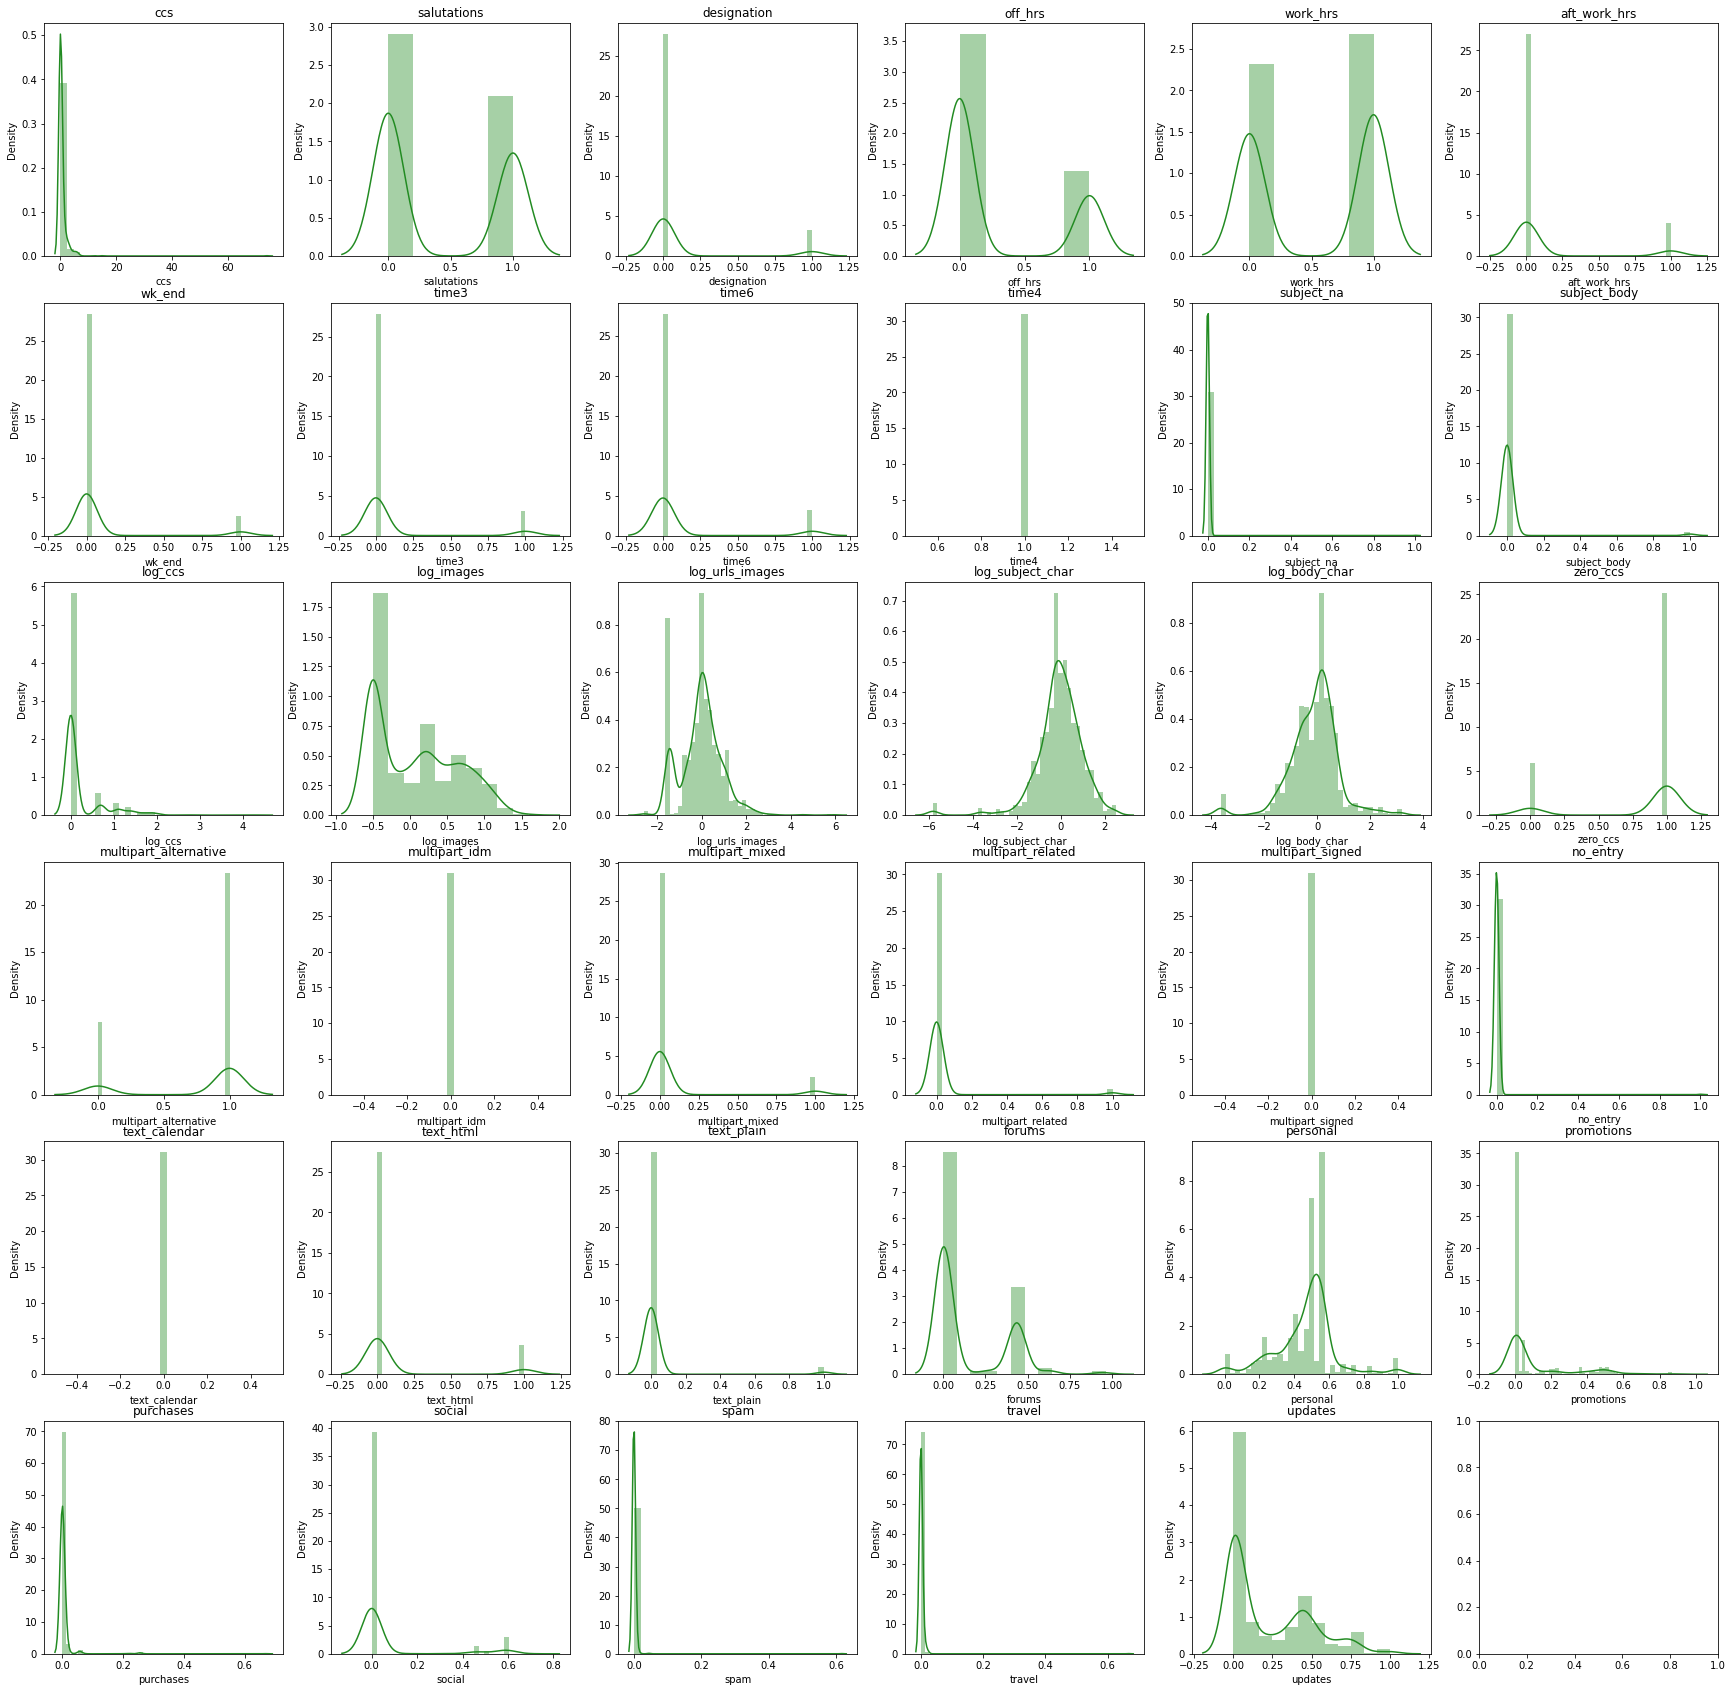

In [ ]:
# Viewing the distribution of numerical data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = train_df.select_dtypes(include=numerics)
newdf=newdf.sample(1000)
newdf = newdf.drop(columns = ['label'])

fig, axes = plt.subplots(nrows = 6, ncols = 6)   
axes = axes.flatten()        
fig.set_size_inches(30, 30)

for ax, col in zip(axes, newdf.columns):
  sns.distplot(newdf[col], ax = ax, color='forestgreen')
  ax.set_title(col)

# Feature-Target Split

In [ ]:
cols = train_df.columns.tolist()
cols.remove('label')
X = train_df[cols]
y = train_df[['label']]
# If PCA
#pca=PCA(n_components='mle')
#X = pca.fit_transform(X)
#pca1=PCA(n_components=33)
#test_df = pca1.fit_transform(test_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# K Nearerst Neighbours

In [ ]:
# a simple KNN classifier using featurized data
parameters = [{
'n_neighbors': [8,10,12,14],
'weights': ['uniform'],
'algorithm': ['ball_tree', 'kd_tree'],
'p' : [1,2]}]

clf = GridSearchCV(KNeighborsClassifier(), parameters, scoring='accuracy')

clf.fit(X, y)
print(clf.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

In [ ]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.362838,0.015729,79.614547,1.711860,ball_tree,14,1,uniform,"{'algorithm': 'ball_tree', 'n_neighbors': 14, ...",0.554877,0.559526,0.567820,0.572997,0.562395,0.563523,0.006328,1
14,0.535934,0.024239,33.447663,0.756086,kd_tree,14,1,uniform,"{'algorithm': 'kd_tree', 'n_neighbors': 14, 'p...",0.555438,0.560586,0.567259,0.571500,0.562457,0.563448,0.005526,2
7,0.364358,0.004777,85.255215,2.053837,ball_tree,14,2,uniform,"{'algorithm': 'ball_tree', 'n_neighbors': 14, ...",0.555001,0.558965,0.560649,0.567633,0.558466,0.560143,0.004171,3
15,0.506825,0.009709,29.250044,0.766677,kd_tree,14,2,uniform,"{'algorithm': 'kd_tree', 'n_neighbors': 14, 'p...",0.555313,0.556595,0.560773,0.564952,0.557406,0.559008,0.003478,4
4,0.366667,0.015656,80.897972,2.635046,ball_tree,12,1,uniform,"{'algorithm': 'ball_tree', 'n_neighbors': 12, ...",0.549514,0.553103,0.562644,0.565201,0.558403,0.557773,0.005820,5
12,0.518783,0.008264,32.865475,0.748851,kd_tree,12,1,uniform,"{'algorithm': 'kd_tree', 'n_neighbors': 12, 'p...",0.548578,0.553976,0.562083,0.565326,0.556595,0.557312,0.005915,6
13,0.510713,0.019202,29.697246,0.496906,kd_tree,12,2,uniform,"{'algorithm': 'kd_tree', 'n_neighbors': 12, 'p...",0.549015,0.551419,0.556969,0.563393,0.555971,0.555353,0.004966,7
5,0.373894,0.013587,88.848874,0.428364,ball_tree,12,2,uniform,"{'algorithm': 'ball_tree', 'n_neighbors': 12, ...",0.548142,0.551731,0.556408,0.562519,0.555597,0.554879,0.004828,8
2,0.365236,0.005894,78.175250,1.798154,ball_tree,10,1,uniform,"{'algorithm': 'ball_tree', 'n_neighbors': 10, ...",0.546832,0.549361,0.554911,0.556408,0.549174,0.551337,0.003671,9
10,0.577763,0.122441,31.980538,0.851093,kd_tree,10,1,uniform,"{'algorithm': 'kd_tree', 'n_neighbors': 10, 'p...",0.547892,0.548238,0.554599,0.557281,0.546617,0.550926,0.004216,10


In [ ]:
pred_y = clf.predict(test_df.fillna(0))
pred_df = pd.DataFrame(pred_y, columns=['label'])
pred_df.to_csv("knn_submission.csv", index=True, index_label='Id')

In [ ]:
from google.colab import files
files.download(r'/content/knn_sample_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Neural Network

In [ ]:
# 50,50 is the pair which gets best result 
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(50,),max_iter = 50,verbose = True,random_state=1)
clf.fit(X, y)
# Model score
r = clf.score(X, y)
print("Accuracy:", r)
# Prediction
y_predict = clf.predict(test_df.fillna(0))  
y_predict = pd.DataFrame(y_predict, columns=['label'])
y_predict.to_csv("NN_submission.csv", index=True, index_label='Id')

In [ ]:
# Tuning the model
parameter = {"hidden_layer_sizes": range(30,100,10),
              "max_iter": range(30,120,10)}
NN_model = MLPClassifier(verbose = True,solver= 'adam')
clf = RandomizedSearchCV(NN_model, parameter)
clf.fit(X, y)
print(clf.best_params_)

In [ ]:
# Model score
#{'max_iter': 40, 'hidden_layer_sizes': 90} is the pair recommended by GridSearchCV
r = clf.score(X, y)
print("Accuracy:", r)
# Prediction
y_predict = clf.predict(test_df.fillna(0))  
y_predict = pd.DataFrame(y_predict, columns=['label'])
y_predict.to_csv("NN_submission.csv", index=True, index_label='Id')

In [ ]:
# Print the result of GridSearchCV
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score').head(10)

In [ ]:
# Cross validation
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(50,),max_iter= 120,verbose = True,random_state=1)
clf.fit(X_train, y_train)
# Model score
y_pred = clf.predict(X_test.fillna(0)) 
print("f1 score macro is :",f1_score(y_test, y_pred, average='macro'))
print("f1 score micro is :",f1_score(y_test, y_pred, average='micro'))
print("f1 score weighted is :",f1_score(y_test, y_pred, average='weighted'))

# XGBoost

In [ ]:
!pip install xgboost --upgrade
import xgboost as xgb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193.6 MB 63 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
             'learning_rate' : [0.05, 0.15, 0.30],
             'max_depth' : [5, 10, 20],
             'min_child_weight' : [ 1, 3, 7],
             'gamma': [0.0, 0.2, 0.4],
             'colsample_bytree' : [0.3, 0.5, 0.7]}

In [ ]:
parameter = {'n_estimators': [50, 100, 150]} 

xgb_model = xgb.XGBClassifier(n_jobs=1)
clf = GridSearchCV(xgb_model, parameter)
clf.fit(X, y)
print(clf.best_params_)

{'n_estimators': 50}


In [ ]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score').head(10)

In [ ]:
pred_y = clf.predict(test_df.fillna(0))
pred_df = pd.DataFrame(pred_y, columns=['label'])
pred_df.to_csv("xgb_submission.csv", index=True, index_label='Id')

In [ ]:
pred_df

,label
0,1
1,0
2,3
3,1
4,0
...,...
34360,7
34361,2
34362,1
34363,0



# CatBoost

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

In [ ]:
# Get the index of categorical features
cat_fea_idx = np.where(X.dtypes != np.float)[0]
cat_model = CatBoostClassifier(iterations=1000 ,
                               depth=4,
                               od_type="Iter",
                               early_stopping_rounds=500,
                               loss_function='MultiClass' )
cat_model.fit(X, y)
pred_y = cat_model.predict(test_df.fillna(0))
pred_df = pd.DataFrame(pred_y, columns=['label'])
pred_df.to_csv("cat_submission.csv", index=True, index_label='Id')

# Default Script

In [ ]:
"""
This script can be used as skelton code to read the challenge train and test
csvs, to train a trivial model, and write data to the submission file.
"""

train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

## Filtering column "mail_type"
train_x = train_df[['mail_type']]
train_x = train_x.fillna(value='None')
train_y = train_df[['label']]

test_x = test_df[['mail_type']]
test_x = test_x.fillna(value='None')

## Do one hot encoding of categorical feature
feat_enc = OneHotEncoder()
feat_enc.fit(np.vstack([train_x, test_x]))
train_x_featurized = feat_enc.transform(train_x)
test_x_featurized = feat_enc.transform(test_x)

## Train a simple KNN classifier using featurized data
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_x_featurized, train_y)
pred_y = neigh.predict(test_x_featurized)

## Save results to submission file
pred_df = pd.DataFrame(pred_y, columns=['label'])
pred_df.to_csv("knn_sample_submission.csv", index=True, index_label='Id')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
